Import Libraries


In [1]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost
from xgboost import XGBClassifier

# Imbalance handling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Save model
import joblib

# Settings
sns.set(style="whitegrid")

 Load Preprocessing Data

In [2]:
#Load cleaned dataset
df = pd.read_csv('/content/cleaned_fake_job_posting.csv')
df.head()

,clean_text,fraudulent
0,marketing intern marketing food fastgrowing ja...,0
1,customer service cloud video production succes...,0
2,commissioning machinery assistant cma client l...,0
3,account executive washington dc sale company e...,0
4,bill review manager job title itemization revi...,0


TF IDF Vectorization

In [3]:
#Initialize vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

#vectorize text
X = vectorizer.fit_transform(df['clean_text'])
Y = df['fraudulent']

Train-Test split

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
print("Before SMOTE:", Counter(Y_train))

Before SMOTE: Counter({0: 13611, 1: 693})


Applying SMOTE on Training Set

In [5]:
sm = SMOTE(random_state=42)
X_resampled, Y_resampled = sm.fit_resample(X_train, Y_train)

print("After SMOTE:", Counter(Y_resampled))

After SMOTE: Counter({0: 13611, 1: 13611})


Train XGBoost model

In [6]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_resampled, Y_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:41:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluate Model on Real Test Set

Accuracy: 0.9812639821029083

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.92      0.67      0.78       173

    accuracy                           0.98      3576
   macro avg       0.95      0.83      0.88      3576
weighted avg       0.98      0.98      0.98      3576



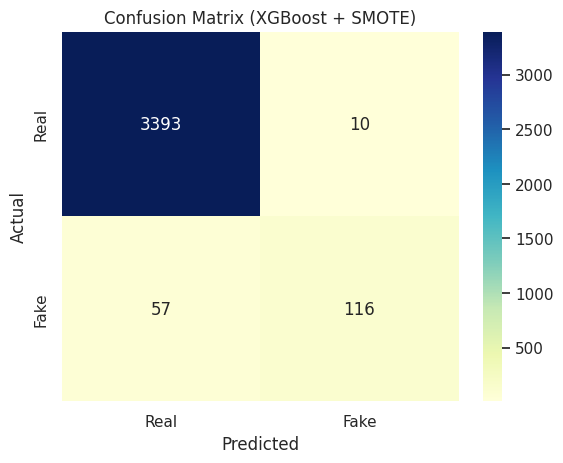

In [7]:
# Predictions
Y_pred = model.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost + SMOTE)")
plt.show()

Saving the Model and Vectorizer

In [8]:
joblib.dump(model, "xgb_fake_job_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

Top Features

In [9]:
features = vectorizer.get_feature_names_out()
importances = model.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

print("🔍 Top Predictive Words for Fake/Real Jobs:")
for idx in top_idx:
    print(f"{features[idx]} → importance: {importances[idx]:.4f}")


🔍 Top Predictive Words for Fake/Real Jobs:
oil → importance: 0.0384
home → importance: 0.0310
data entry → importance: 0.0305
income → importance: 0.0223
free → importance: 0.0208
within → importance: 0.0206
cash → importance: 0.0205
responsibility include → importance: 0.0188
duty → importance: 0.0152
work home → importance: 0.0143
integral → importance: 0.0116
sponsored → importance: 0.0105
worklife → importance: 0.0103
facility → importance: 0.0101
computer → importance: 0.0097
integral part → importance: 0.0095
passionate → importance: 0.0091
wage → importance: 0.0091
time → importance: 0.0084
apply → importance: 0.0079
